# Ad-hoc LCE
#### Where toy-mc is the law but G4 is avoided like the devil

In [8]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

In [9]:
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh

In [60]:
len(mesh.hex_centers)

3808

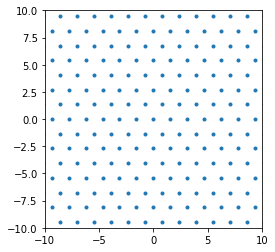

In [65]:
plt.plot(mesh.hex_centers[:,0],mesh.hex_centers[:,1], ls = '', marker = '.')
plt.ylim(-10,10)
plt.xlim(-10,10)
plt.gca().set_aspect('equal')
plt.show()

#### Get the pattern on the array from one of the hex centers

We follow Physics convention: theta is inclination, phi is azimuthal and r is r.

In [9]:
def get_xy_on_plane(x0,y0,z0,directions,z_prime):
    '''
    Return the (x,y) of the intersection of a vector with direction 
    (theta,phi), physics convention, starting at point (x0,y0,z0) and
    finishing at the plane z=z_prime.
    '''
    x_prime = x0 + (z_prime-z0) * np.cos(directions[:,1]) * np.tan(directions[:,0])
    y_prime = y0 + (z_prime-z0) * np.sin(directions[:,1]) * np.tan(directions[:,0])
    
    return np.stack((x_prime, y_prime), axis = 1)

In [10]:
z_anode = 10

In [11]:
x0,y0,z0 = 0,0,0

n_traces = 100000

thetas = np.random.uniform(0,np.pi/2,n_traces)
phis = np.random.uniform(0,2*np.pi,n_traces)
directions = np.stack((thetas,phis), axis = 1)

In [12]:
final_pos = get_xy_on_plane(x0,y0,z0,directions, z_anode)

In [13]:
final_pos.shape

(100000, 2)

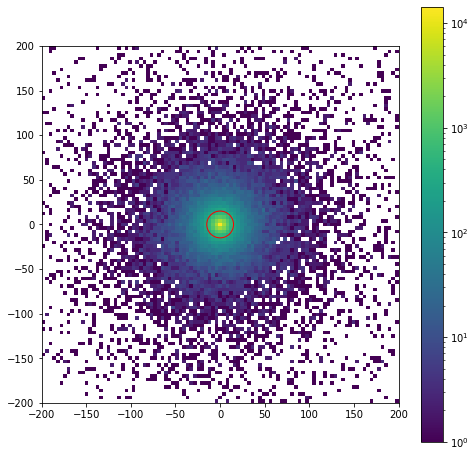

In [14]:
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1, figsize = (8,8))
hist2d = ax.hist2d(final_pos[:,0], final_pos[:,1],
           bins = (np.linspace(-200,200,100),np.linspace(-200,200,100)),
           cmin = 1, norm = LogNorm())#, density = True)

fig.colorbar(hist2d[3])
ax.add_patch(Circle((0,0),15,fill = False, color = 'r'))
ax.set_aspect('equal')
plt.show()

In [15]:
final_r = TPC.get_r(final_pos[:,0],final_pos[:,1])
mask_r = final_r < 15
final_pos_array = final_pos[mask_r]
print('Initial number of photons: %s'%n_traces)
print('Number of photons in array: %s (%.2f%% of produced, %.2f of full emission)'%(len(final_pos_array),
                                                                                  len(final_pos_array)/n_traces*100,
                                                                                  len(final_pos_array)/n_traces*100/2))

Initial number of photons: 100000
Number of photons in array: 62447 (62.45% of produced, 31.22 of full emission)


In [16]:
def get_ph_in_array(n_ph, x0,y0,z0,z_anode=10,r_max=30):
    thetas = np.random.uniform(0,np.pi/2,n_traces)
    phis = np.random.uniform(0,2*np.pi,n_traces)
    directions = np.stack((thetas,phis), axis = 1)
    final_pos = get_xy_on_plane(x0,y0,z0,directions, z_anode)
    final_r = TPC.get_r(final_pos[:,0],final_pos[:,1])
    mask_r = final_r < r_max
    final_pos_array = final_pos[mask_r]
    return final_pos_array

In [17]:
pos = get_ph_in_array(10000,-5,7,0)

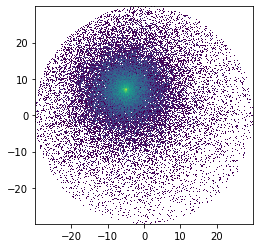

In [18]:
plt.hist2d(pos[:,0],pos[:,1], bins = 300, norm = LogNorm())
plt.gca().set_aspect('equal')
plt.show()

#### Make histogram with defined bin size and map

In [19]:
x_bin_step = 1#0.1 #mm
y_bin_step = 1#0.1 #mm
x_min = y_min = -np.ceil(r_max*1.1)
x_max = y_max = np.ceil(r_max*1.1)

x_bin_sides = np.arange(x_min,x_max+x_bin_step*0.1,x_bin_step)
y_bin_sides = np.arange(y_min,y_max+x_bin_step*0.1,y_bin_step)
x_bin_middles = x_bin_sides[:-1] + x_bin_step/2
y_bin_middles = y_bin_sides[:-1] + y_bin_step/2

hist2d = np.histogram2d(pos[:,0],pos[:,1],
                        bins = (x_bin_sides,y_bin_sides),
                                density = False) 
#density could be True but we can also do it by hand given the bin area and total of photons
#It's even better because it can be normalized properly from the start taking into account 
#the photonos projected downwards and the ones that miss the array.

In [20]:
xx, yy = np.meshgrid(x_bin_middles, y_bin_middles, indexing ='ij')

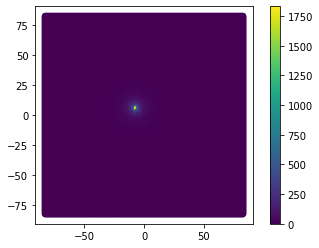

In [21]:
plt.scatter(xx,yy,c = hist2d[0])
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

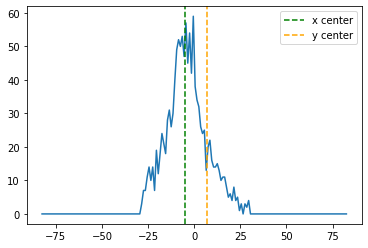

In [22]:
plt.plot(x_bin_middles,hist2d[0][:,80])
plt.axvline(-5, ls = '--', c = 'green', label ='x center')
plt.axvline(7, ls = '--', c = 'orange', label ='y center')
plt.legend()
plt.show()

In [23]:
#from hist2d to 2dpdf
assert np.sum(hist2d[0]) == len(pos), 'Lost some photons on the histogram??'
bin_area = x_bin_step*y_bin_step
total_in_hist = np.sum(hist2d[0])
hist_density = hist2d[0] /bin_area/(n_traces*2) #fraction/mm^2

/tmp/jobs/19717591/ipykernel_137/2049973765.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(xx,yy,c = np.log(hist_density*100))


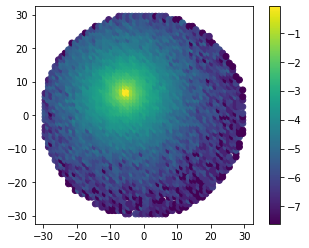

In [24]:
plt.scatter(xx,yy,c = np.log(hist_density*100))
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

In [26]:
hist_density.shape

(166, 166)

In [29]:
interp2s = scipy.interpolate.RectBivariateSpline(x_bin_middles, 
                                                 y_bin_middles,
                                                 hist_density)

In [30]:
interp2s(0,0)

array([[0.00035222]])

#### Test from class

In [14]:
def plot_pattern_reconstruction(toy_events, x_bin_middles,y_bin_middles,reconstructed_toys,pattern):
    fig, axs = plt.subplots(1,3, figsize = (10,3),dpi = 300)

    axs[0].set_title('Toy events')
    toys = axs[0].hist2d(toy_events[:,0],toy_events[:,1],cmin = 1, norm=LogNorm(), bins = 100)
    axs[0].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[0].set_aspect('equal')
    axs[0].set_xlim(-80,80)
    axs[0].set_ylim(-80,80)
    fig.colorbar(toys[3], ax = axs[0])

    axs[1].set_title('Normalized distribution [mm$^{-2}]$')
    _xx,_yy = np.meshgrid(x_bin_middles,y_bin_middles, indexing='ij')
    _zz = hist_density

    reconstructed_toys = axs[1].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3)

    axs[1].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[1].set_aspect('equal')
    fig.colorbar(reconstructed_toys, ax = axs[1])

    axs[2].set_title('Pattern interpolation\n(spline, k=3)')
    _x = np.arange(-80,80,1)
    _y = np.arange(-80,80,1)
    _xx,_yy = np.meshgrid(_x,_y, indexing='ij')
    _rr = TPC.get_r(_xx,_yy)
    _xx = _xx[_rr < Xenoscope.radius]
    _yy = _yy[_rr < Xenoscope.radius]
    _zz = pattern.ev(_xx,_yy)
    interpolated = axs[2].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)

    axs[2].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[2].set_aspect('equal')
    fig.colorbar(interpolated, ax = axs[2])

    plt.show()

In [30]:
scintillation = LCEPattern(Xenoscope)
scintillation.define_pattern_props(x_bin_step = 1, y_bin_step = 1, 
                                   n_traces = 1e6, smooth_pattern = False)

In [31]:
toy_events = scintillation.get_hits_on_circ_array(0,40,5)
x_bin_middles,y_bin_middles,reconstructed_toys = scintillation.get_pattern_density_hist2d(toy_events)
pattern = scintillation.make_pattern_density(toy_events)

/tmp/jobs/19730792/ipykernel_101/1198995967.py:16: RuntimeWarning: divide by zero encountered in log10
  reconstructed_toys = axs[1].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3)
/tmp/jobs/19730792/ipykernel_101/1198995967.py:30: RuntimeWarning: invalid value encountered in log10
  interpolated = axs[2].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)


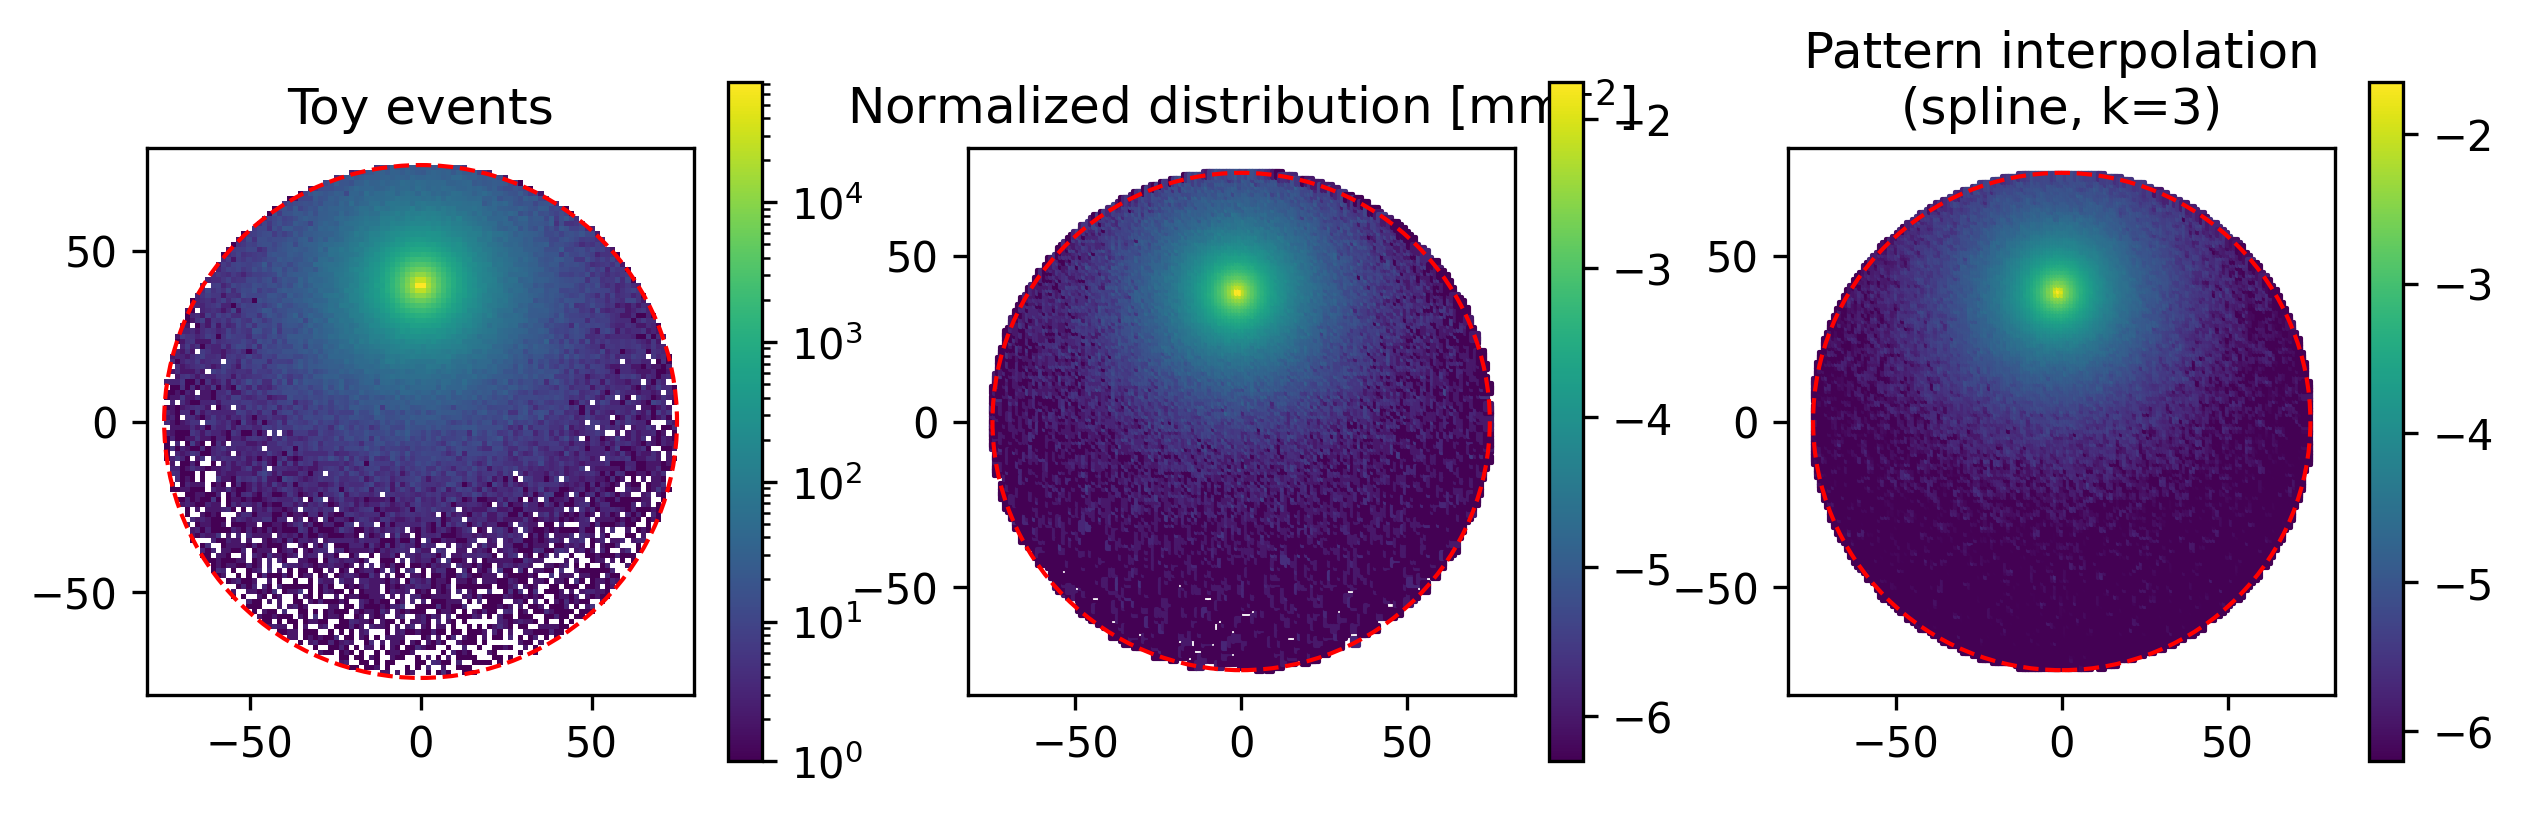

In [32]:
plot_pattern_reconstruction(toy_events, x_bin_middles,y_bin_middles,reconstructed_toys,pattern)

#### Getting a pattern for each hex center

In [88]:
initial_toy_pos = np.hstack((mesh.hex_centers, Xenoscope.liquid_level *np.ones((mesh.n_hexes,1))))

In [89]:
initial_toy_pos[:5]

array([[-42.9       , -44.58298779,   5.        ],
       [-41.34      , -44.58298779,   5.        ],
       [-39.78      , -44.58298779,   5.        ],
       [-38.22      , -44.58298779,   5.        ],
       [-36.66      , -44.58298779,   5.        ]])

In [90]:
# I'm too tired for vectorization
def make_pattern_local(x0,y0,z0):
    toy_events = scintillation.get_hits_on_circ_array(x0,y0,z0)
    pattern = scintillation.make_pattern_density(toy_events)
    return pattern

#interpfunctions = dict()

In [13]:
scintillation = LCEPattern(Xenoscope)
scintillation.define_pattern_props(x_bin_step = 1, y_bin_step = 1, 
                                   n_traces = 1e6, smooth_pattern = False,
                                   force_traces = True)

for hex_id,hex_position in tqdm(enumerate(initial_toy_pos), total = mesh.n_hexes):
    pattern = make_pattern_local(hex_position[0],hex_position[1],hex_position[2])
    with open('patterns/hex_v0_%d.\pck'%hex_id, 'wb') as file:
        pickle.dump(pattern, file)

100%|██████████| 3808/3808 [19:25<00:00,  3.27it/s]


In [98]:
def plot_pattern(pattern, hex_id):
    fig,ax = plt.subplots(1,1,figsize = (9,9), dpi = 100)
    ax.set_title('Pattern interpolation\n(spline, k=3)')
    _x = np.arange(-80,80,1)
    _y = np.arange(-80,80,1)
    _xx,_yy = np.meshgrid(_x,_y, indexing='ij')
    _rr = TPC.get_r(_xx,_yy)
    _xx = _xx[_rr < Xenoscope.radius]
    _yy = _yy[_rr < Xenoscope.radius]
    _zz = pattern.ev(_xx,_yy)
    interpolated = ax.scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)

    ax.add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    ax.set_aspect('equal')
    fig.colorbar(interpolated, ax = ax)
    
    plt.savefig('figures/patterns/hex_v0_%d' %hex_id)